# Model diagnostics and performance

Load The Data

In [1]:
# Load pickled data
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
%matplotlib inline

# Load up the augmented training datasign_names = pd.read_csv('signnames.csv')
validation_file='../data/valid.p'
testing_file = '../data/test.p'

with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
sign_names = pd.read_csv('signnames.csv')

In [2]:
# Helper functions
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten


In [3]:

# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1

def flatten_conv(x, input_shape, output_len):
    if input_shape[0] * input_shape[1] * input_shape[2] - output_len:
        raise Exception('Input and output shape mismatch while flattening')
    return flatten(x)

def fc_relu(x, input_len, output_len):
    _fc = fc(x, input_len, output_len)
    return  tf.nn.relu(_fc)

def fc(x, input_len, output_len):
    fc_W  = tf.Variable(tf.truncated_normal(shape=(input_len, output_len), mean = mu, stddev = sigma))
    fc_b  = tf.Variable(tf.zeros(output_len))
    _fc    = tf.matmul(x, fc_W) + fc_b
    return _fc

def max_pool(x, input_shape, output_shape, kernel_width=2, stride=2):
    input_width = input_shape[0]
    output_width = output_shape[0]
    if input_width/2 == output_width:
        return tf.nn.max_pool(x, ksize=[1, kernel_width, kernel_width, 1], strides=[1, stride, stride, 1], padding='VALID')
    elif input_width == output_width:
        return tf.nn.max_pool(x, ksize=[1, kernel_width, kernel_width, 1], strides=[1, 1, 1, 1], padding='SAME')

def conv2d_relu(x, input_shape, output_shape, kernel_width = 5, strides=[1, 1, 1, 1]):
    """
    Define a standard convolution layer with relu activation
    """
    input_width = input_shape[0]
    input_depth = input_shape[2]
    output_width = output_shape[0]
    kernel_depth = output_shape[2]
    if output_width % 2:
        raise Exception('Output shape is odd. Not supported at the moment')
    elif  input_shape[0]!= input_shape[1] or output_shape[0]!= output_shape[1]:
        raise Exception('Only square images supported')
    if input_shape[0] == output_shape[0]:
        padding = 'SAME'
    elif input_shape[0] > output_shape[0]:
        padding = 'VALID'
        if input_width - output_width + 1 - kernel_width:
            raise Exception(
                'Kernel width of {} does not support {} - {} convolution'.format(
                    kernel_width,input_width,output_width))
    else:
        raise Exception('Output size is larger than input')

    conv_W = tf.Variable(tf.truncated_normal(shape=(kernel_width, kernel_width, input_depth, kernel_depth), mean = mu, stddev = sigma))
    conv_b = tf.Variable(tf.zeros(kernel_depth))
    conv = tf.nn.conv2d(x, conv_W, strides=strides, padding=padding) + conv_b
    return tf.nn.relu(conv)

# Model training

### Model Architecture

In [4]:
def KNet(x, return_layer = None):        
    # Convolutional layer #1
    h1 = conv2d_relu(x, input_shape=(32,32,3),output_shape=(32,32,5), kernel_width=3)
    h2 = max_pool(h1, input_shape = (32,32,5), output_shape=(32,32,5))
    #h = tf.nn.dropout(h, 0.5)

    # Convolutional layer #2
    h3 = conv2d_relu(h2, input_shape=(32,32,5),output_shape=(32,32,10), kernel_width=3)
    h4 = max_pool(h3, input_shape = (32,32,10), output_shape=(32,32,10))

    # Convolutional layer #3
    h5 = conv2d_relu(h4, input_shape=(32,32,10),output_shape=(32,32,20), kernel_width=3)
    h6 = max_pool(h5, input_shape = (32,32,20), output_shape=(32,32,20))
    h7 = tf.nn.dropout(h6, 0.5)

    # Convolutional layer #4
    h8 = conv2d_relu(h7, input_shape=(32,32,20), output_shape=(28,28,25), kernel_width=5)
    h9 = max_pool(h8, input_shape = (28,28,25), output_shape=(14,14,25))

    # Convolutional layer #5
    h10 = conv2d_relu(h9, input_shape=(14,14,25), output_shape=(10,10,30), kernel_width=5)
    h11 = max_pool(h10, input_shape = (10,10,30), output_shape=(5,5,30))
    #h = tf.nn.dropout(h, 0.5)

    # Flatten convolution
    h12   = flatten_conv(h11, input_shape=(5,5,30), output_len=750)
    
    # Fully connected layers
    h13 = fc_relu(h12, input_len=750, output_len=43)
    h14 = fc(h13, input_len=43, output_len=43)
    if not return_layer:
        return h14
    elif return_layer == 1:
        return h1
    elif return_layer == 2:
        return h2
    elif return_layer == 3:
        return h3
    elif return_layer == 4:
        return h4
    elif return_layer == 5:
        return h5
    elif return_layer == 10:
        return h10

### Train, Validate and Test the Model

In [5]:
BATCH_SIZE = 128
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
is_training = tf.placeholder(tf.bool, True)
one_hot_y = tf.one_hot(y, 43)
rate = tf.placeholder(tf.float32, [])
logits = KNet(x)
softmax = tf.nn.softmax(logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

layer1 = KNet(x)
layer2 = KNet(x, return_layer=2)
layer3 = KNet(x, return_layer=3)
layer4 = KNet(x, return_layer=4)
layer5 = KNet(x, return_layer=5)
layer6 = KNet(x, return_layer=10)


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples



In [6]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.950


It looks like the model has a 95 % acccuracy on the test dataset

In [12]:
def get_class(X_data):
    sess = tf.get_default_session()
    num_examples = len(X_data)
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_data[offset:offset+BATCH_SIZE]
        l = sess.run(softmax, feed_dict={x: batch_x})
        return l

---

## Step 3: Test a Model on New Images


### Load and Output the Images

In [8]:
files = glob.glob('new_images/*')
new_data = []
new_data_full_size = []
for f in files:
    img =cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_data_full_size.append(img)
    rs_img = cv2.resize(img, (32, 32))
    new_data.append(rs_img)

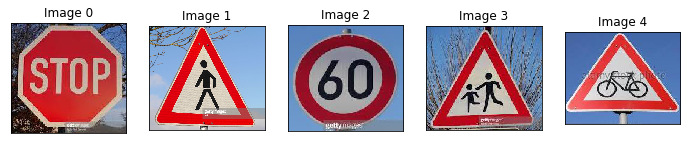

In [9]:
fig, axes = plt.subplots(1, 5, figsize=(12, 6), subplot_kw={'xticks': [], 'yticks': []})
indices = range(len(new_data))
for ax, index in zip(axes.flat, indices):
    new_test_data = new_data_full_size[index]
    ax.imshow(new_test_data)
    ax.set_title('Image {}'.format(index))
fig.subplots_adjust(hspace=0.4, wspace=0.2)
plt.show()

After resizing the downloaded images ...

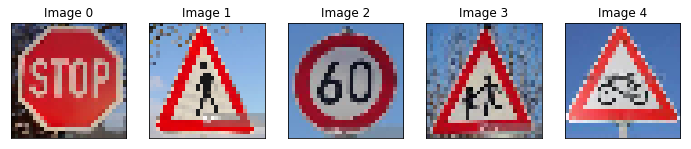

In [10]:
fig, axes = plt.subplots(1, 5, figsize=(12, 6), subplot_kw={'xticks': [], 'yticks': []})
indices = range(len(new_data))
for ax, index in zip(axes.flat, indices):
    new_test_data = new_data[index]
    ax.imshow(new_test_data)
    ax.set_title('Image {}'.format(index))
fig.subplots_adjust(hspace=0.4, wspace=0.2)
plt.show()

### Predict the Sign Type for Each Image

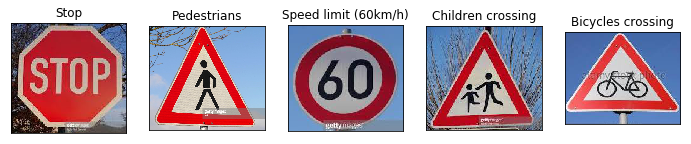

In [21]:
fig, axes = plt.subplots(1, 5, figsize=(12, 6), subplot_kw={'xticks': [], 'yticks': []})
indices = range(len(new_data))
metadata = []
for ax, index in zip(axes.flat, indices):
    new_test_data = new_data[index]
    ax.imshow(new_data_full_size[index])
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        new_data_predictions = get_class([new_test_data])
        p = new_data_predictions[0]
        highest_logit = np.argmax(p)
        predicted_class = sign_names['SignName'][highest_logit]
        
        top_5_indices = p.argsort()[-5:][::-1]
        top_5_prob = p[top_5_indices]
        top_5_names = sign_names['SignName'][top_5_indices]
        metadata.append(
        {
            'img': new_data_full_size[index],
            'predicted_class': predicted_class,
            'top_5_prob': top_5_prob,
            'top_5_names': top_5_names,
        })
    ax.set_title('{}'.format(predicted_class))
fig.subplots_adjust(hspace=0.4, wspace=0.2)
plt.show()

It looks like we got all 5 images (100 %) right !

In [22]:
def get_plot(m):
    fig = plt.figure()
    ax = fig.add_subplot(221)
    b = range(5)
    ax.barh(b,m['top_5_prob'])
    plt.yticks(b,list(m['top_5_names']))
    fig.add_subplot(222)
    plt.imshow(m['img'])
    plt.xticks([])
    plt.yticks([])

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

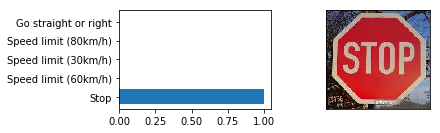

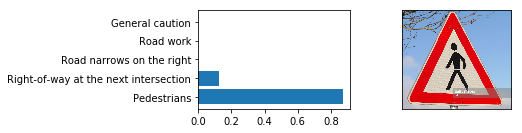

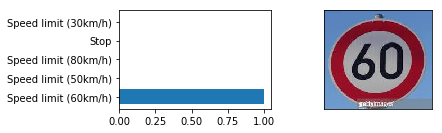

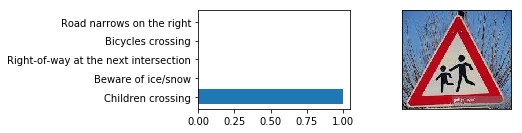

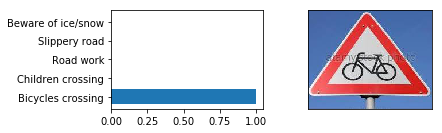

In [23]:
get_plot(metadata[0])
get_plot(metadata[1])
get_plot(metadata[2])
get_plot(metadata[3])
get_plot(metadata[4])